In [1]:
import os
os.chdir('..')

In [2]:
"""
    Plan:

    1. Train a model that predicts the number of departures within a given area over time
    
    2. Predict the ride value
    
    3. Use both models to predict the probability to get at least 1 rides with a value above a given threshold
    
    The relevant code can be found in `src/lr.py`.
    The complete code might be available at https://github.com/ImScientist/carrrrs
"""


import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from scipy.stats import gamma
from sklearn.cluster import KMeans
from sklearn.metrics import mean_poisson_deviance, mean_absolute_error
from sklearn.calibration import calibration_curve

# IMPORT CUSTOM CODE
import src.lr as cc

# Number of areas (=16) used in our world approximation
WORLD_SIZE = cc.WORLD_SIZE
DATA_PATH = '/Users/ivanova/Documents/projects/data/carrrrrrs/robotex5.csv'
print(WORLD_SIZE)

16


In [3]:
"""
    Load data and remove outliers (end locations with wrong `lat` and `lng`)
"""

df = cc.load_and_clean_data(DATA_PATH)
df.head(2)

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,dist
0,2022-03-06 15:02:39.329452,59.40791,24.689836,59.513027,24.831630,3.51825,14.175101
1,2022-03-10 11:15:55.177526,59.44165,24.762712,59.426450,24.783076,0.50750,2.045785


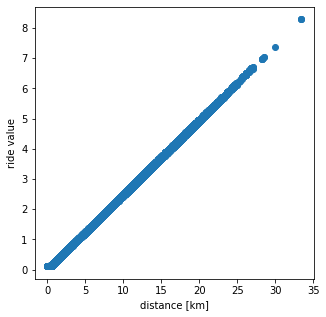

In [37]:
"""
    Ride value was constructed from the geodesic distance btw the start and end location ...
"""

plt.figure(figsize=(5,5))
plt.scatter(df['dist'], df['ride_value'])
plt.xlabel('distance [km]')
plt.ylabel('ride value')
plt.show()

In [5]:
"""
    Split the map into areas;
    
    We will use KMeans clustering to define the different areas
    and to assign every point to one of them.
"""

df_sample = df.sample(10_000)

clu = KMeans(n_clusters=WORLD_SIZE)
pred = clu.fit_predict(df_sample[['start_lng', 'start_lat']].values)

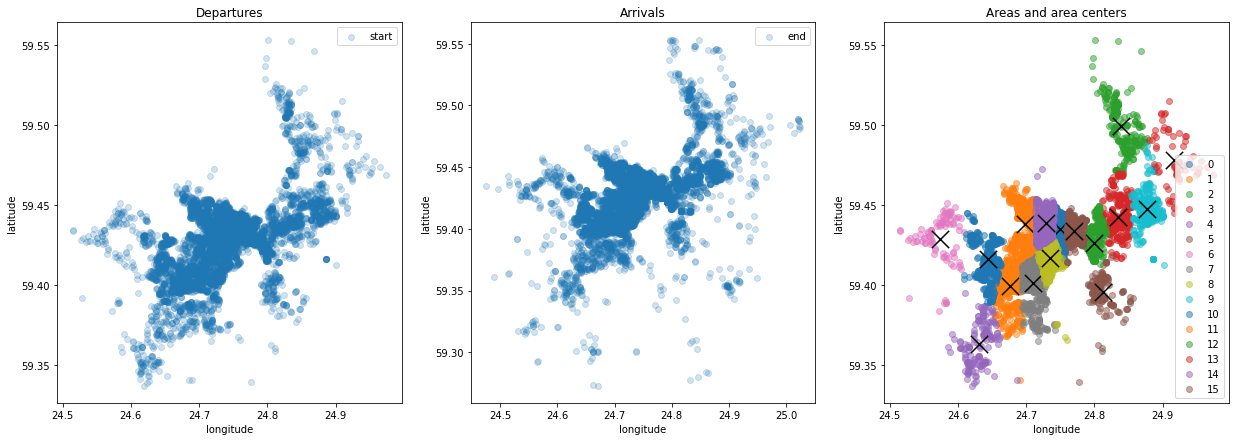

In [6]:
fig = plt.figure(figsize=(21, 7))

ax = plt.subplot(1, 3, 1)
ax.scatter(df_sample['start_lng'], df_sample['start_lat'], alpha=.2, label='start')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.legend()
ax.set_title('Departures')

ax = plt.subplot(1, 3, 2)
ax.scatter(df_sample['end_lng'], df_sample['end_lat'], alpha=.2, label='end')
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.legend()
ax.set_title('Arrivals')

ax = plt.subplot(1, 3, 3)
for i in range(WORLD_SIZE):
    plt.scatter(df_sample['start_lng'].iloc[pred==i].values,
                df_sample['start_lat'].iloc[pred==i].values, label=f'{i}', alpha=.5)
    plt.scatter(clu.cluster_centers_[[i], 0],
                clu.cluster_centers_[[i], 1], marker='x', s=300, c='black')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.legend()
ax.set_title('Areas and area centers')

plt.show()

### Train a model that predicts the number of departures within a given area over time

In [7]:
"""
    - Map the location of every departure to one of the areas
    - Coarse-grain the time (resolution in multiples of 600 seconds)
"""

df['a_i'] = clu.predict(df[['start_lng', 'start_lat']].values)
df['start_time_cg'] = cc.get_time_cg(t=df['start_time'], t_window=600)

In [8]:
"""
    - Prepare the training dataset
        * count the number of departures within a time window of 600 seconds
        * later we will assume that these counts are generated from samples of
          a random variable with a Poisson distribution Poisson(lambda)
        * lambda = avg nubmer of departures within a time period of 600 seconds
"""

data = (
    df
    .groupby(['start_time_cg', 'a_i'])
    .agg(n=('start_time', 'count'))
    .unstack(['a_i'])
    .fillna(0)
    .sort_values(['start_time_cg'])
)

data.columns = data.columns.droplevel(0).values

data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
start_time_cg,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,37.0,8.0,0.0,1.0,1.0,0.0,2.0,5.0,5.0,1.0,4.0,5.0,2.0,2.0,10.0,10.0
2022-03-01 00:10:00,60.0,11.0,4.0,3.0,2.0,0.0,1.0,4.0,6.0,0.0,4.0,8.0,1.0,2.0,11.0,9.0
2022-03-01 00:20:00,55.0,5.0,1.0,3.0,1.0,1.0,0.0,7.0,2.0,2.0,3.0,2.0,2.0,0.0,14.0,5.0
2022-03-01 00:30:00,42.0,7.0,4.0,3.0,2.0,1.0,0.0,2.0,1.0,2.0,7.0,1.0,3.0,0.0,6.0,5.0
2022-03-01 00:40:00,40.0,1.0,1.0,5.0,0.0,0.0,1.0,3.0,3.0,1.0,5.0,3.0,3.0,0.0,5.0,6.0


In [9]:
"""
    Check if there are missing time indices btw t_min and t_max;
    No missing time indices;
"""

data.reset_index()['start_time_cg'].diff().value_counts()

0 days 00:10:00    4031
Name: start_time_cg, dtype: int64

In [10]:
"""
    Define training/validation/test datasets

    Test: week 4
    Training + Validation: week 1,2,3
    Train/val splits:
        * split 1: week 1 training; week 2 validation
        * split 2: week 1,2 training; week 3 validation
"""

idx_trval_i = '2022-03-01'
idx_trval_f = '2022-03-21'
idx_te_i = '2022-03-22' 
idx_te_f = '2022-03-28'

y = data
x = pd.DataFrame(index=data.index).assign(t=data.index)

x_trval = x.loc[idx_trval_i: idx_trval_f]
y_trval = y.loc[idx_trval_i: idx_trval_f]

x_te = x.loc[idx_te_i: idx_te_f]
y_te = y.loc[idx_te_i: idx_te_f]

display(x_trval.head(2),
        y_trval.head(2))

,t
start_time_cg,
2022-03-01 00:00:00,2022-03-01 00:00:00
2022-03-01 00:10:00,2022-03-01 00:10:00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
start_time_cg,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,37.0,8.0,0.0,1.0,1.0,0.0,2.0,5.0,5.0,1.0,4.0,5.0,2.0,2.0,10.0,10.0
2022-03-01 00:10:00,60.0,11.0,4.0,3.0,2.0,0.0,1.0,4.0,6.0,0.0,4.0,8.0,1.0,2.0,11.0,9.0


In [11]:
"""
    Model pipeline:
        - apply it separately to each one of the 16 areas
        - for simplicity, we have ignored any possible correlations between
          the past values of the time series
    
    Features:
        - trend: a feature column that increases linearly with time (1dim-vector)
        - OHE hour (24 dim-vector)
        - OHE weekday (7dim-vector)
    
    Model:
        - PoissonRegressor
        - We assume that the observed counts are generated from a Poisson process Poisson(lambda(t))
          with lambda that is varying with time
        - Even though it is natural to assume that lambda(t) should vary 
          smoothly with time we have not included any autoregressive term
          in the model: we want to keep things simple.
          We conmpensate this by coarse-graining the time such that we can
          get more observations within a discrete time step.

    Hyperparameter tuning:
        - Use `GridSearchCV` to find the best regularization parameter of the PoissonRegressor
        - Use `neg_mean_poisson_deviance` to score the models
"""

rf = cc.RegressorFamily()
rf.fit(x_trval, y_trval)
y_te_hat = rf.predict(x_te)
y_trval_hat = rf.predict(x_trval)

rf.summary

,name,best_score,best_params
0,0,-1.720958,{'poisson__alpha': 0.1}
1,1,-1.364160,{'poisson__alpha': 0.1}
2,2,-1.232305,{'poisson__alpha': 0.001}
3,3,-1.203657,{'poisson__alpha': 0.01}
4,4,-1.298702,{'poisson__alpha': 0.01}
5,5,-1.276183,{'poisson__alpha': 0.01}
6,6,-1.333494,{'poisson__alpha': 0.01}
7,7,-1.284828,{'poisson__alpha': 0.01}
8,8,-1.470861,{'poisson__alpha': 0.01}
9,9,-1.235389,{'poisson__alpha': 0.01}


In [12]:
"""
    - The mean poisson deviance increases by 10% in the test dataset;

    - To make the error interpretable for humans we have also plotted the MAE.
      The variance of a poisson process Poisson(lambda) is lambda.
      
      => It makes sense to get higher MAE for areas with higher number 
         of departures per time interval.
      
      => If the number of departures increses over time MAE should also increase
"""

summary = pd.DataFrame(index=np.arange(WORLD_SIZE))
summary['poiss_dev_tr'] = [mean_poisson_deviance(y_trval[i] , y_trval_hat[:,i]) for i in range(WORLD_SIZE)]
summary['poiss_dev_te'] = [mean_poisson_deviance(y_te[i] , y_te_hat[:,i]) for i in range(WORLD_SIZE)]
summary['err_growth'] = (summary['poiss_dev_te'] - summary['poiss_dev_tr']) / summary['poiss_dev_tr']

summary['mae_tr'] = [mean_absolute_error(y_trval[i] , y_trval_hat[:,i]) for i in range(WORLD_SIZE)]
summary['mae_te'] = [mean_absolute_error(y_te[i] , y_te_hat[:,i]) for i in range(WORLD_SIZE)]

summary['avg rides per time interval'] = data.mean()

summary.round(2)

,poiss_dev_tr,poiss_dev_te,err_growth,mae_tr,mae_te,avg rides per time interval
0,1.60,1.77,0.11,5.67,6.65,34.98
1,1.29,1.38,0.07,2.81,3.19,11.10
2,1.18,1.23,0.04,1.50,1.67,3.56
3,1.15,1.25,0.09,2.01,2.31,6.32
4,1.22,1.21,-0.01,1.25,1.36,2.45
5,1.21,1.20,-0.01,1.20,1.30,2.28
6,1.20,1.29,0.07,0.96,1.09,1.47
7,1.22,1.26,0.04,2.67,3.01,10.72
8,1.28,1.43,0.12,2.83,3.23,11.32
9,1.19,1.22,0.02,1.82,2.06,5.10


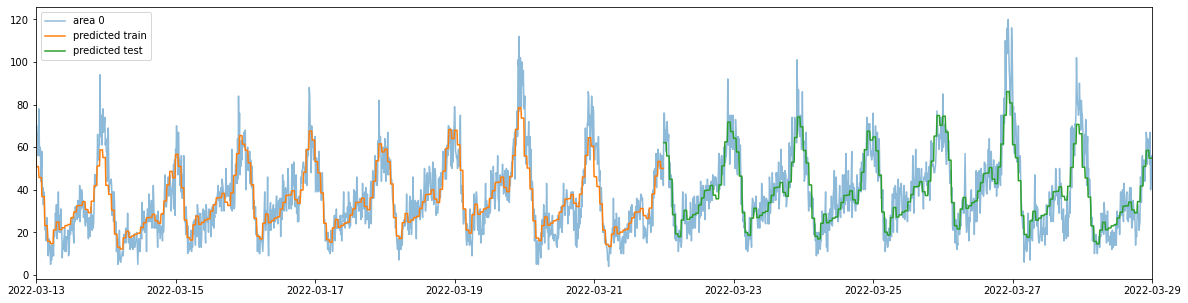

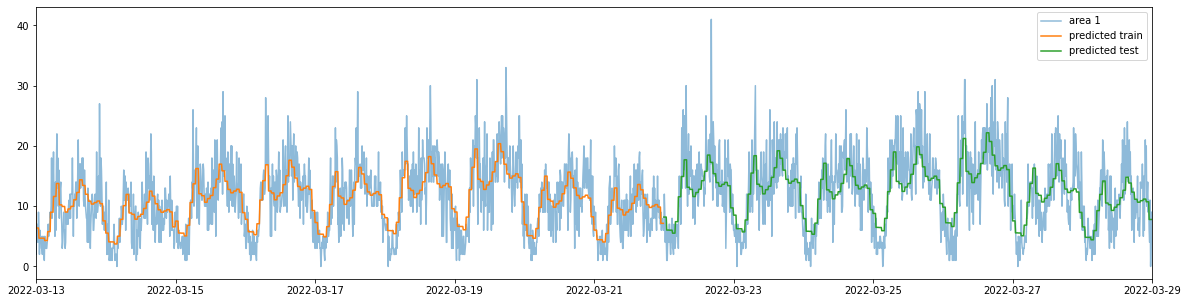

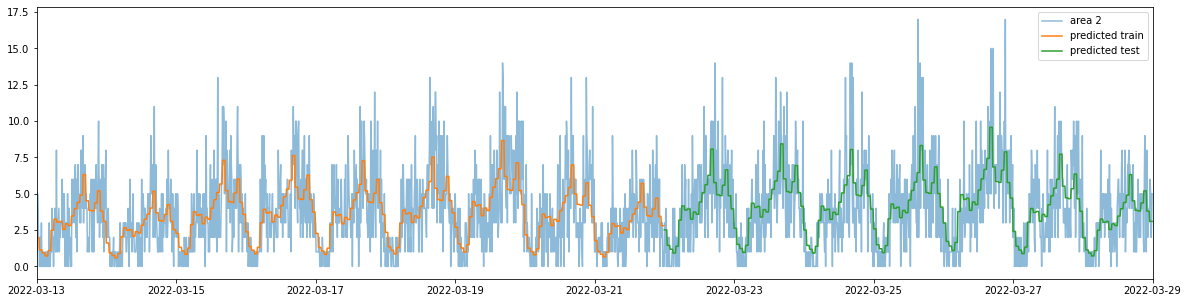

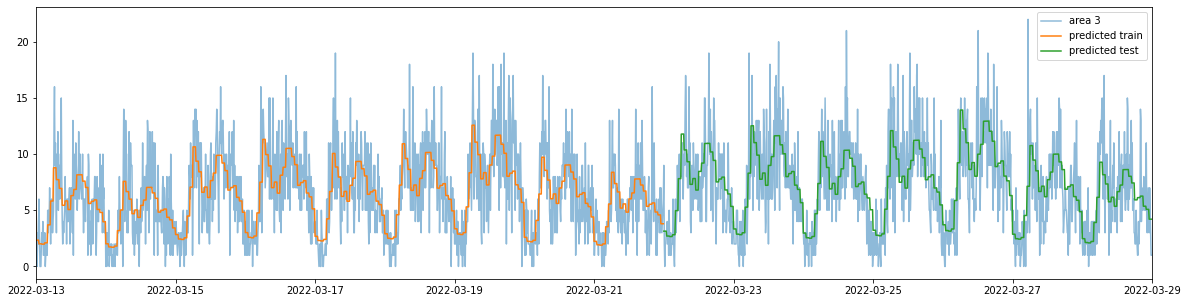

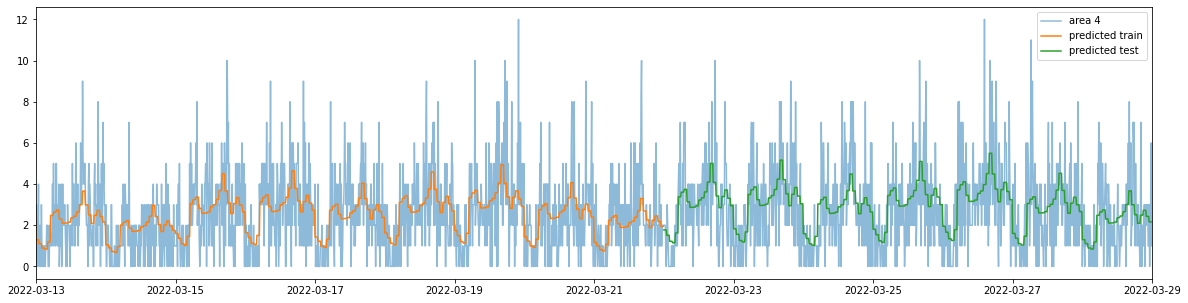

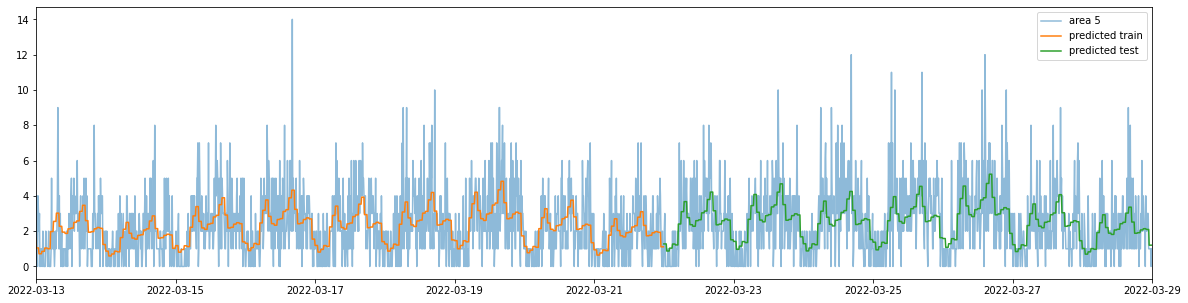

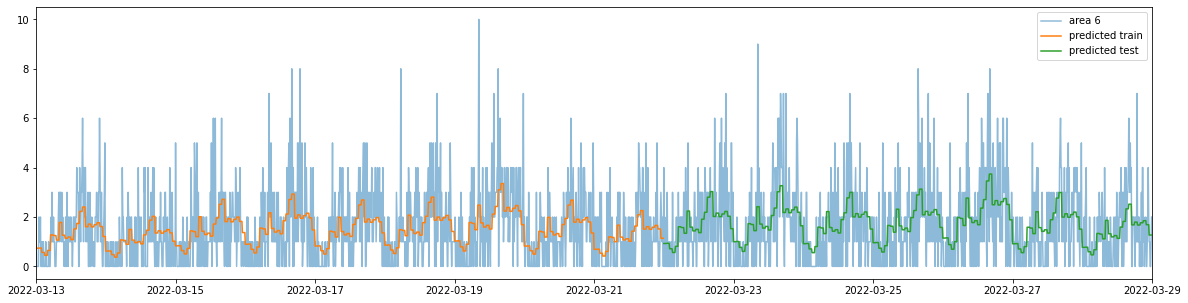

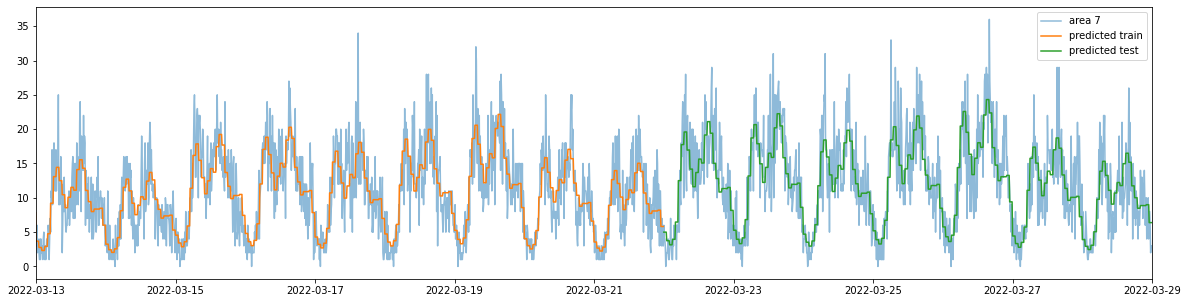

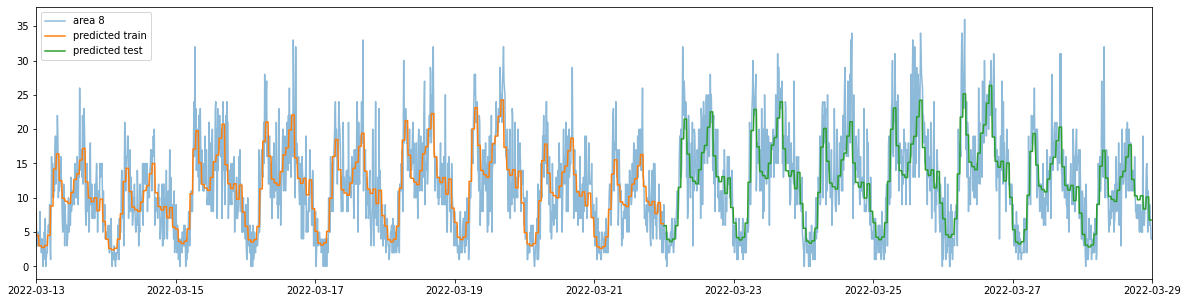

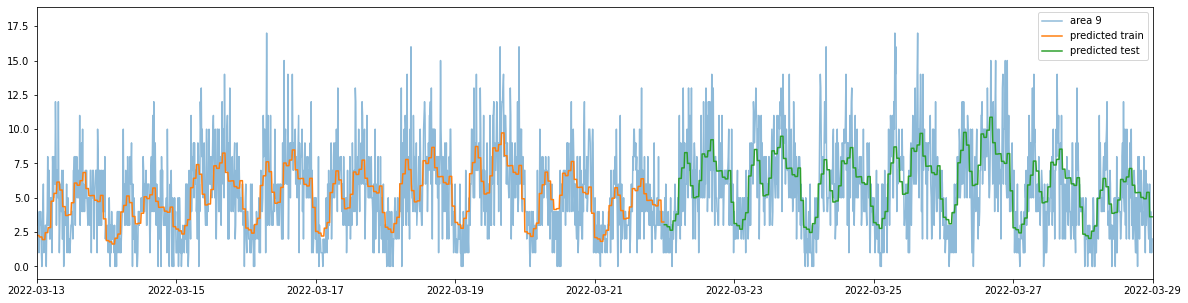

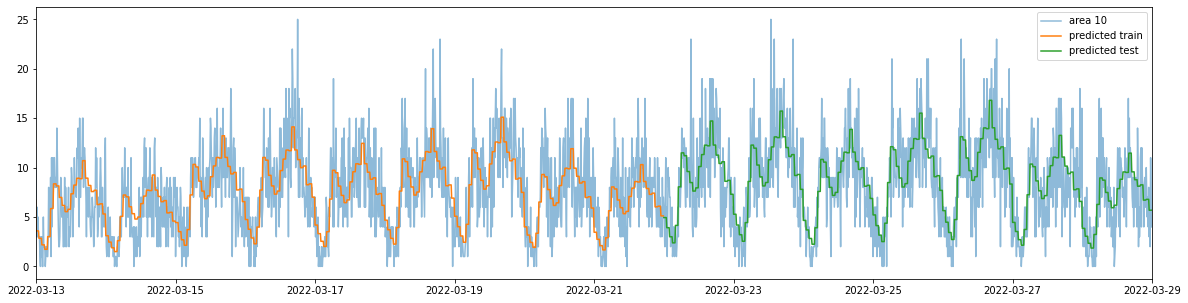

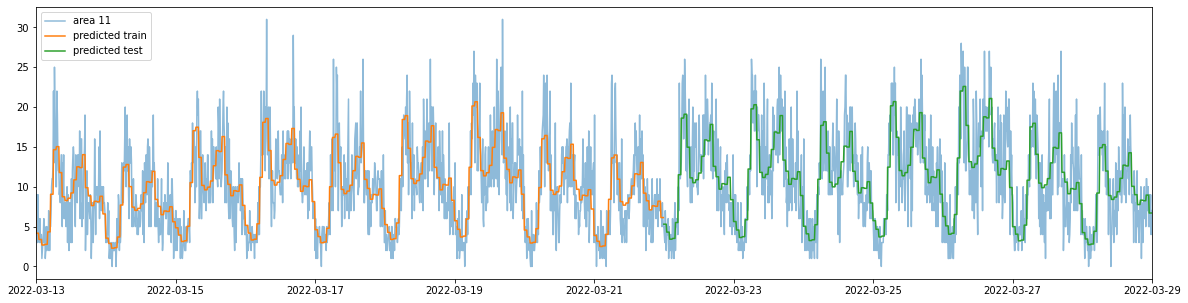

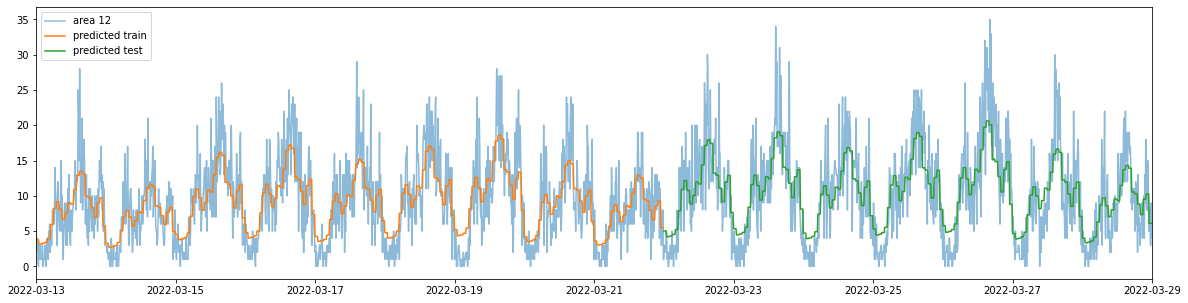

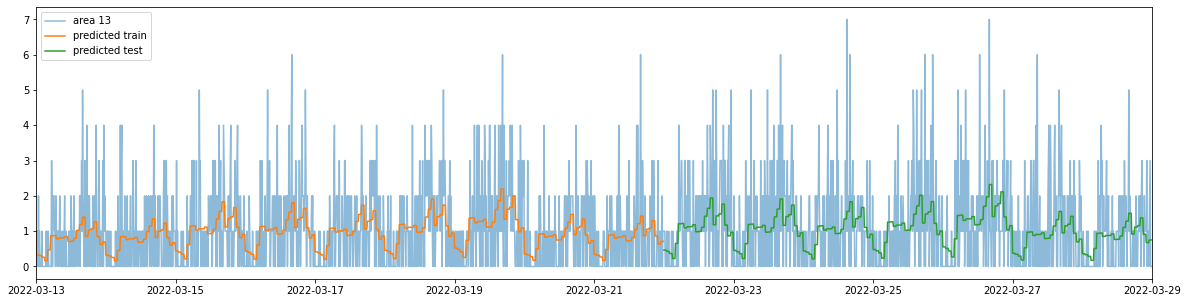

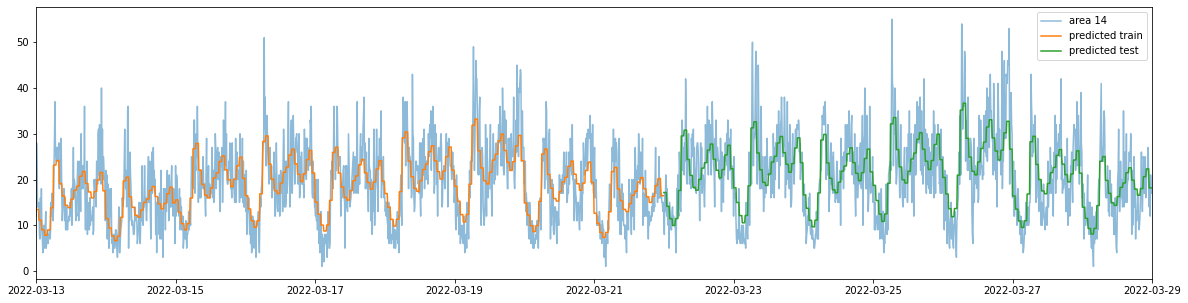

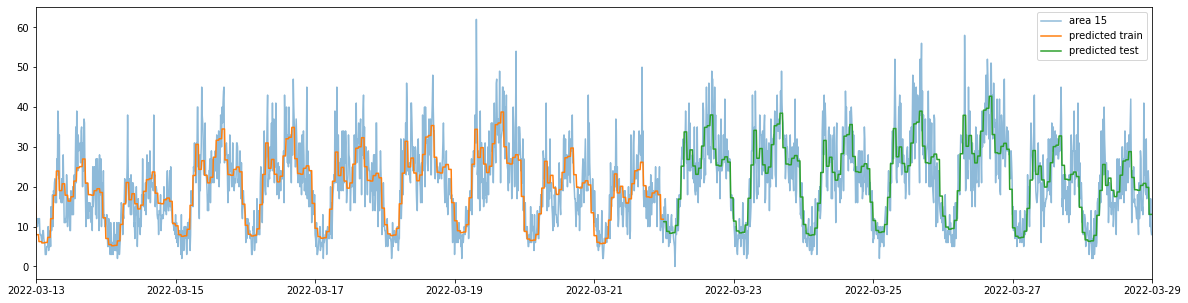

In [33]:
"""
    Visualize the predictions; 
"""

for i in range(WORLD_SIZE):
    plt.figure(figsize=(20,5))
    
    plt.plot(y[i], alpha=.5, label=f'area {i}')
    plt.plot(pd.Series(index=x_trval.index, data=y_trval_hat[:,i]), label='predicted train')
    plt.plot(pd.Series(index=x_te.index, data=y_te_hat[:,i]), label='predicted test')

    plt.xlim(dt.datetime(2022, 3, 13), dt.datetime(2022, 3, 29))
    plt.legend()
    plt.show()

### Predict the ride value

In [14]:
"""
    We assume that the ride value `R` for every departure within a given area `A` is sampled
    from a random variable with distribution `p_{ride_value}(R,A)` that may or may not vary with time.
    
    To check if `p_{ride_value}(R,A)` varies with time for every A we have plotted
    the time evolution of the percentiles (25, 50, 75) of the ride values for every hour.
    
    These percentiles follow a straight line over time
    => we can assume that `p_{ride_value}(R,A)` does not depend on time.
    
    Then we can look at the distribution of ride values for every area A.
    - It is different for every area.
    - We will approximate it with a generalized Gamma(alpha, beta) distribution.
    - The parameters alpha, beta will be different for every area.
"""
print()

q_25     q_50      q_75    n  ride_value_mean
t          a_i                                                   
2022-03-01 0    0.280375  0.63875  1.275625  288         0.865113
           1    1.136875  1.54075  1.912625   35         1.578600
           2    2.246375  2.57925  2.857875   10         2.636975
           3    1.150125  1.54375  1.962312   16         1.652187
           4    2.005500  2.15550  2.707125    6         2.144958

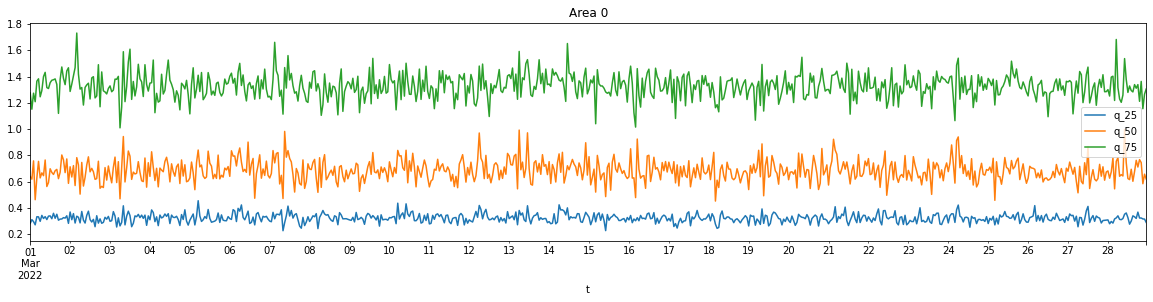

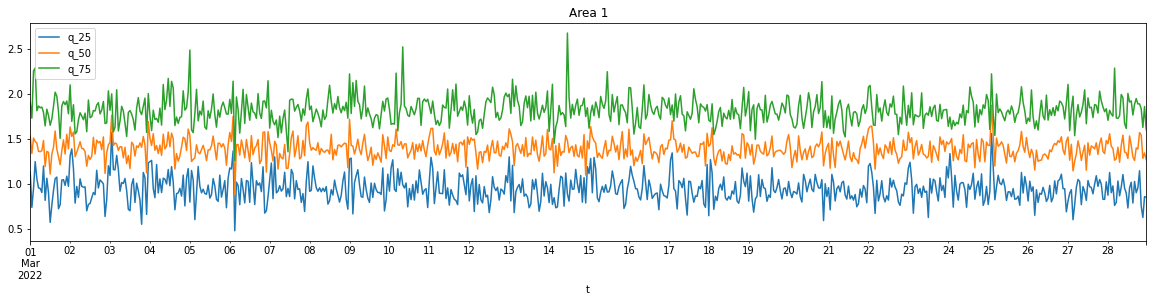

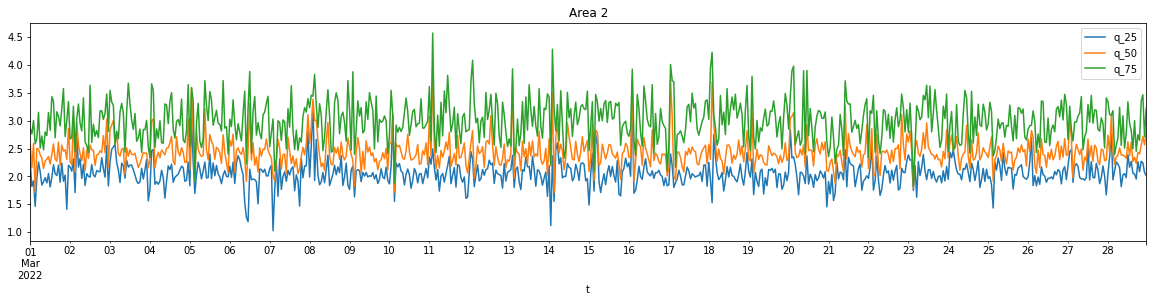

In [30]:
"""    
    To check if `p_{ride_value}(R,A)` varies with time for every A we have plotted
    the time evolution of the percentiles (25, 50, 75) of the ride values for every hour.
    
    These percentiles follow a straight line over time
    => we can assume that `p_{ride_value}(R,A)` does not depend on time.
"""

data_ride_qtiles = (
    df
    .assign(t=lambda x: cc.get_time_cg(x['start_time'], t_window=3600))
    .groupby(['t', 'a_i'])
    .agg(q_25 = ('ride_value', lambda x: x.quantile(0.25)),
         q_50 = ('ride_value', lambda x: x.quantile(0.50)),
         q_75 = ('ride_value', lambda x: x.quantile(0.75)),
         n = ('ride_value', 'count'),
         ride_value_mean = ('ride_value', 'mean'),
        )
)

display(data_ride_qtiles.head())

# Only the first 3 areas are shown
idx = pd.IndexSlice
for i in range(3):
    data_ride_qtiles.loc[idx[:,[i]],['q_25', 'q_50', 'q_75']].droplevel(1).plot(figsize=(20,4), title=f'Area {i}')

In [41]:
"""
    Maximum likelihood estimation (MLE) for the probability distribution (pdf) of ride values
        
    We can look at the distribution of ride values for every area A.
    - It is different for every area.
    - We will approximate it with a generalized Gamma(alpha, beta) distribution.
    - The parameters alpha, beta will be different for every area.
"""

# MLE for the pdf of ride values
mle_params = cc.mle_ride_value_pdf(df)

# pd.DataFrame(mle_params)

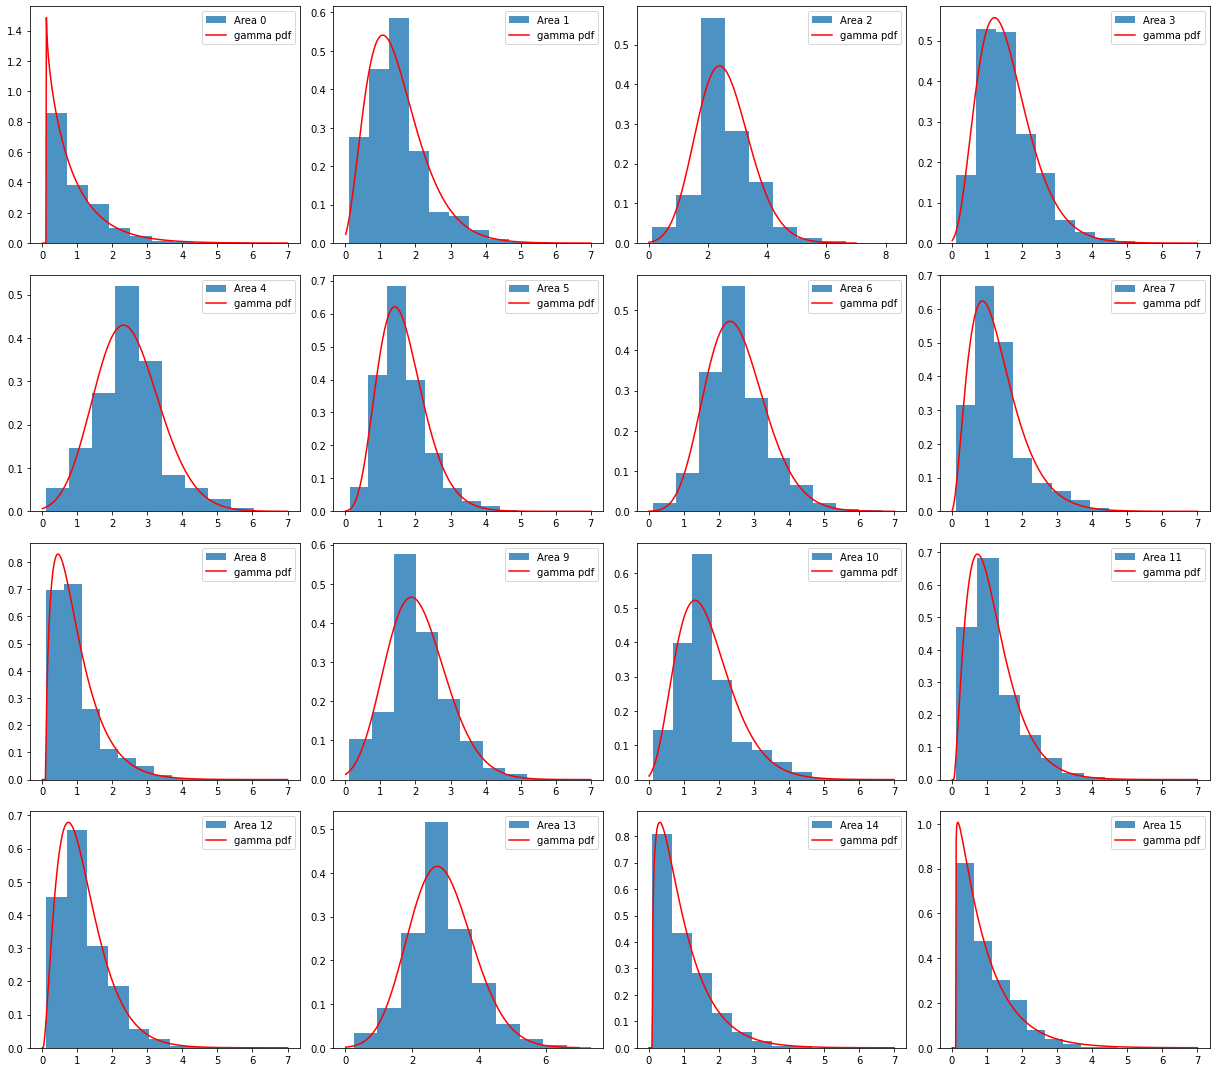

In [17]:
"""
    Compare the fitted distributions...
"""


fig = plt.figure(figsize=(17, 15))

x = np.linspace(.01, 7, 500)

for i in range(WORLD_SIZE):
    params = mle_params[i]
    
    ax = plt.subplot(4, 4, i + 1)
    
    ax.hist(df.loc[(df['a_i']==i), 'ride_value'],
            label=f'Area {i}',
            alpha=.8,
            density=True)
    
    ax.plot(x,
            gamma.pdf(x, params['a'], params['loc'], params['scale']),
            color='red',
            label='gamma pdf')
    
    ax.legend()

plt.tight_layout()
plt.show()

### Use both models to predict the probability to get at least 1 ride with a value above a given threshold

In [18]:
"""    
    - We assume that the generated number of departures `N` and ride values {R_1, R_2, ... R_N}
      are sampled from two distributions:
        * p(n): Poisson distribution for the number of departures;
          The lambda parameters of the distribution are obtained from the predictions of the already 
          trained Poisson regression model;
        * gamma(r): Gamma distribution for the ride values
    - We assume that p(n) and gamma(r) are independent from each other, i.e.
      their joint probability distribution factorizes over the corresponding marginal distributions.
    
    - We will define a threshold above which a ride is considered as valuable.
    - We will estimate the probability that there is at least one customer in given area A and time window T
      with ride value above the given threshold.
    - The details how this probability is calculated are given below
"""

print()

$$
\begin{align*}
v_{threshold} & =  \text{ threshold above which a ride is valuable} \\
\gamma(v) & = \text{distribution of the ride values in a given area} \\
p(n|\lambda) & = \text{probability to get n rides within an area} \\
            & = \frac{\lambda^n \exp(-\lambda) }{n!} \\
p_{worth} & = \text{probability that a ride value is above the threshold defined above} \\
        & = 1 - \int^{v_{threshold}}_{0} \gamma(v) \cdot dv \\
\rho\left(p_{worth}, m | n \right) & = \text{probability that m or more out of n rides have a value above the threshold} \\
        & = \sum^{N}_{m'=m} \binom{n}{m'} p^{m'}_{worth} \cdot (1 - p_{worth})^{n-m'}\\
p_{final} & = \text{probability to get at least m rides with a value above the threshold devined above} \\
    & = \sum^{\infty}_{n=m} \rho\left(p_{worth}, m | n \right) \cdot  p(n|\lambda)
\end{align*}
$$

In [19]:
"""
    Threshold above which a ride is considered as valuable
"""

threshold = 3

In [21]:
"""
    Time intervals with at least one valuable ride
"""

z = (
    df
    .assign(valuable_ride=lambda x: (x['ride_value']>threshold).astype(int))
    .groupby(['start_time_cg', 'a_i'])
    .agg(valuable_ride=('valuable_ride', 'sum'))
    .assign(valuable_ride=lambda x: (x['valuable_ride'] > 0).astype(int))
    .unstack(['a_i'])
    .fillna(0)
)

z.columns = z.columns.droplevel(0).values

z_te = z.loc[idx_te_i: idx_te_f]
z_te.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
start_time_cg,,,,,,,,,,,,,,,,
2022-03-22 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2022-03-22 00:10:00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-03-22 00:20:00,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-03-22 00:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2022-03-22 00:40:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [23]:
"""
    Predictions if there is at least one valuable ride
    
    We will apply it only to the first 3 areas (it is slow)
"""

z_te_hat = pd.DataFrame(index=z_te.index)

for i in range(3):
    z_te_hat[i] = [cc.get_prob_n_worth_rides(1, threshold, mle_params[i], lam=lam) for lam in y_te_hat[:,i]]
    
z_te_hat.head()

,0,1,2
start_time_cg,,,
2022-03-22 00:00:00,0.843001,0.352315,0.522209
2022-03-22 00:10:00,0.843026,0.352338,0.522244
2022-03-22 00:20:00,0.843051,0.352362,0.522279
2022-03-22 00:30:00,0.843075,0.352385,0.522314
2022-03-22 00:40:00,0.843100,0.352408,0.522348


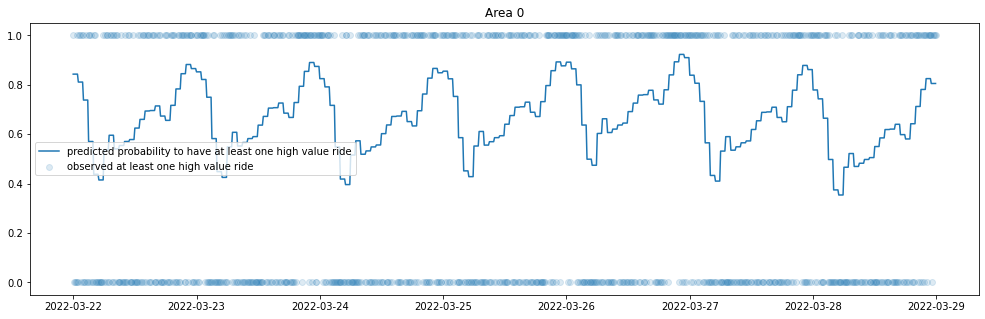

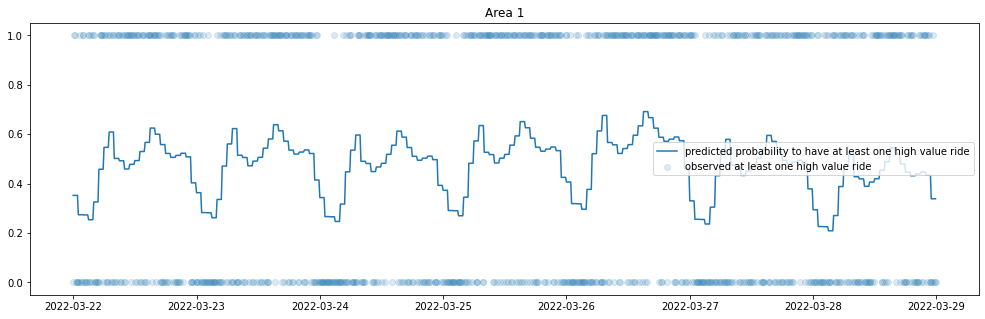

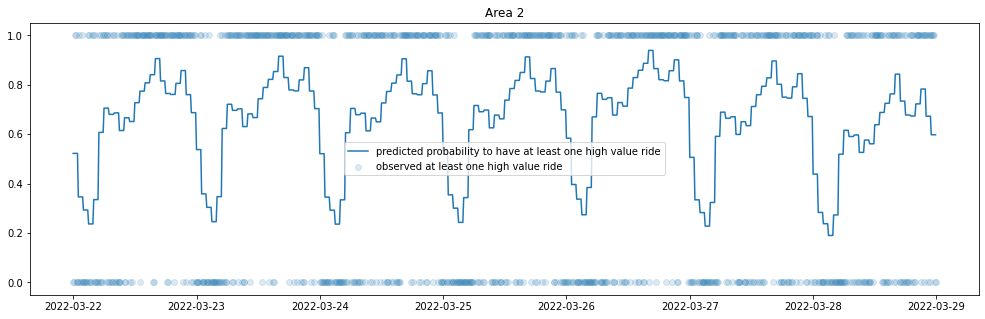

In [36]:
"""
    Compare predictions with observed data
    
    Interpret:
        - the dots as observations of a Bernoulli process (outcomes of flipping a coin)
        - the solid line as the predicted probability to observe heads of a coin flip
    
    In our case we have to replace the event of flipping a coin with 
    the event of observing at least one ride that has a high value within a time window of
    600 seconds.
    
    To understand if the model works we have to see if the predicted probabilities for a
    positive event correspond to the observed fractions of positive events.
"""

for i in range(3):
    plt.figure(figsize=(17,5))
    plt.plot(z_te_hat.index, z_te_hat[i].values, label='predicted probability to have at least one high value ride')
    plt.scatter(z_te.index, z_te[i].values, alpha=.15, label = 'observed at least one high value ride')
    plt.legend()
    plt.title(f"Area {i}")
    plt.show()

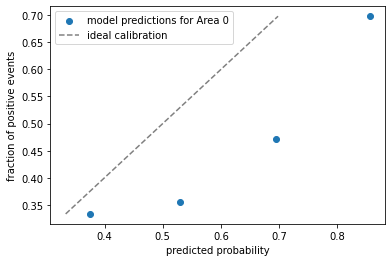

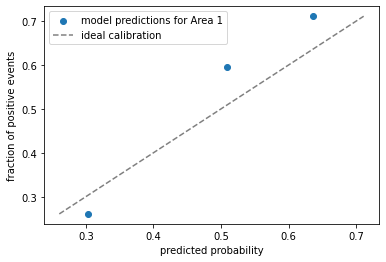

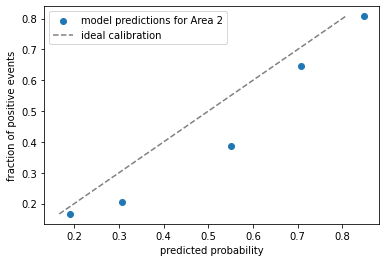

In [25]:
"""
    The predicted probabilities are positively correlated with 
    the observed frations of positive events.
    
    (at least for the first 3 models)
"""

for i in range(3):

    prob_true, prob_pred = calibration_curve(z_te[i].values, z_te_hat[i].values)

    plt.scatter(prob_pred, prob_true, label=f'model predictions for Area {i}')
    plt.plot(prob_true, prob_true, color='grey', linestyle='dashed', label='ideal calibration')
    plt.ylabel('fraction of positive events')
    plt.xlabel('predicted probability')
    plt.legend()
    plt.show()

In [27]:
"""
    Describe how you would deploy such a model
    
    - I assume that the drivers already have an app that assits them in taking a decision where to drive.
    - This app, most likely, sends data to and receives data from the company servers
    - We can deploy our model such that it communicates only with the server, and let the server pass
      the relavant info to the drivers app.
    - We can use a gRPC Service ML Model Deployment
      * Due to the schema specification of the input/output data a lot of misunderstandings
        between the teams maintaining the sever and the deployed model can be avoided
      * Data serialization before sending it to the server could reduce the network load      
"""

"""
    Think through and describe the randomized experiment (AB-test) for live operations
        
    I would not test this model (at least not in this form):
    - If you give the same predictions to all drivers they might cluster in few locations
    - In the ideal case I would like to have an algorithm that:
        * takes a decision about the number of cars that have to be allocated in 
          different areas.
        * gives orders to all drivers
    - In this many-body optimization problem we can find an optimal solution that:
        * minimizes the average driver idle time
        * minimizes the burned fuel when the vehicle is empty
        * maximizes the profit through picking high value rides
    - To measure the effectiveness of the algorithm I would need:
        * a control group
        * a test group that recieves orders from our model
      Both groups should operate in the same city at the same time.
    - We can the compare the metrics, described above, between the two groups.
"""

print()